# Introducción a Aplicaciones de Ciencia de Datos en Finanzas

## Trabajo Final

### Integrantes:

- Carla Dayan
- Juan Segundo Balbin
- Rodrigo Basavilbaso

### 🎯 Problema a abordar

El objetivo de este trabajo es desarrollar un modelo de detección de fraude en transacciones con tarjetas de crédito, utilizando técnicas de ciencia de datos sobre un conjunto real de datos altamente desbalanceado. Se busca identificar operaciones fraudulentas minimizando el costo total de errores, considerando la asimetría entre los falsos positivos y los falsos negativos.


In [64]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve

# Benford's Law
from benfordslaw import benfordslaw

# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración de gráficos
sns.set(style='whitegrid')
%matplotlib inline


Se procede a hacer la carga de datos

In [65]:
# Carga de datos
df = pd.read_csv("data/fraudTest.csv")
# Eliminamos obs porque es solo un índice y no aporta valor predictivo
df = df.drop(columns=['obs'])

# Dimensión del dataset
print(df.shape)

df.head()


(555719, 22)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## 🔍 Análisis Exploratorio (EDA)
Distribución de la variable isFraud

Estadísticas descriptivas

Outliers y valores faltantes

Correlaciones y VIF

Clustering con PCA

Tests de Benford

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64


[13-08-2025 23:22:02] [matplotlib.category] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[13-08-2025 23:22:02] [matplotlib.category] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


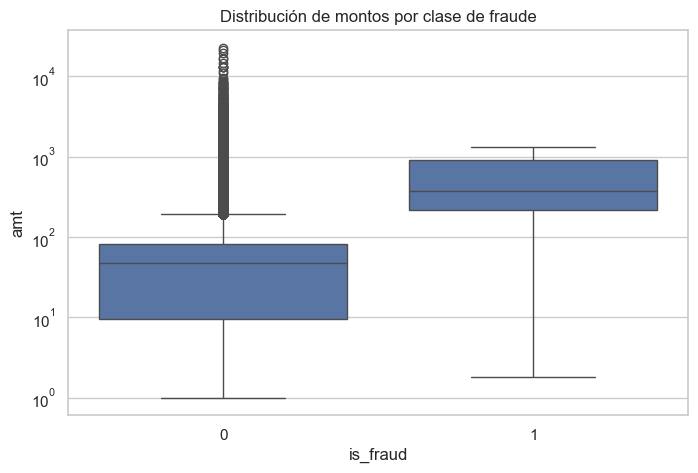

In [66]:
# Proporción de fraudes
print(df['is_fraud'].value_counts(normalize=True))

# Visualización de montos (filtrando valores no positivos y NaN)
df_plot = df[(df['amt'] > 0) & (~df['amt'].isna())]

plt.figure(figsize=(8,5))
sns.boxplot(data=df_plot, x='is_fraud', y='amt')
plt.yscale('log')
plt.title('Distribución de montos por clase de fraude')
plt.show()

### Análisis de correlaciones
Se calcula la matriz de correlación entre las variables numéricas, excluyendo `is_fraud` y aquellas no relevantes para este análisis (`zip`, `lat`, `long`).  
Se identifican pares con correlación alta (|ρ| > 0.8) que podrían generar redundancia o multicolinealidad, y que justificarían una reducción de dimensionalidad.  
En caso de no encontrarse correlaciones fuertes, se optará por PCA como herramienta exploratoria para visualizar estructuras y posibles clusters.


Variables altamente correlacionadas: []


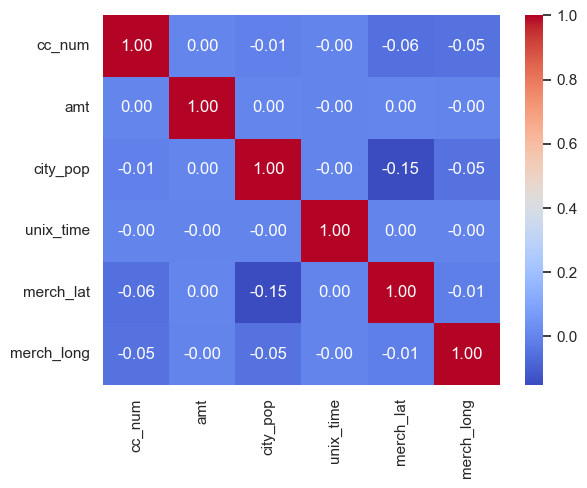

In [67]:
# Selección de variables numéricas
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features.remove('is_fraud')
num_features.remove('zip')
num_features.remove('lat')
num_features.remove('long')

# Matriz de correlación
corr = df[num_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

# Variables con correlación alta
high_corr = [(i, j) for i in num_features for j in num_features if i != j and 
             abs(corr.loc[i, j]) > 0.8]
print("Variables altamente correlacionadas:", high_corr)


**Correlaciones**  
La matriz de correlación no muestra relaciones lineales fuertes entre los predictores (no se observan pares con |ρ| ≥ 0.8). Por lo tanto, la reducción de dimensionalidad basada solo en eliminar variables altamente correlacionadas no resulta justificable.

**Decisión**  
Con el objetivo de:

  1. Facilitar la **visualización** en 2D/3D y 
  2. Detectar posibles **estructuras latentes** (clusters) no evidentes con correlaciones simples,
  
procedemos a aplicar **PCA (Principal Component Analysis)** sobre las variables numéricas estandarizadas, excluyendo columnas no predictivas/IDs.
Reportamos la varianza explicada por los primeros componentes, el **scree plot** y las cargas (loadings) para interpretar qué variables impulsan cada componente.


## Preprocesamiento: 
### Qué hacemos y por qué

**Objetivo.** Dejar un dataset **numérico, limpio y sin fuga de información** para:
1) EDA (correlaciones, outliers, PCA),
2) modelado posterior (árboles/ensembles y modelos lineales).
La idea es **reducir ruido**, **evitar leakage** y **controlar la cardinalidad** de categóricas.

---


In [68]:
# --- Trabajamos con una copia del DataFrame original para preprocesamiento ---
df_pp = df.copy()

### 1) Eliminación de columnas no predictivas / PII (Personally Identifiable Information)
- **`cc_num`, `trans_num`, `first`, `last`, `street`, `Unnamed: 0`/ `obs`** → identificadores o datos personales.
- **Por qué**: no tienen relación causal con fraude; pueden inducir *data leakage* y aumentan dimensionalidad sin valor.

---


In [69]:


# --- dropeamos columnas no predictivas / PII / IDs ---
drop_cols = ['Unnamed: 0', 'cc_num', 'trans_num', 'first', 'last', 'street', 'obs']
df_pp = df_pp.drop(columns=[c for c in drop_cols if c in df_pp.columns], errors='ignore')


### 2) Ingeniería de fechas
- A partir de **`trans_date_trans_time`** y **`dob`** se crean:
  - **`age`** (años),
  - **`trans_hour`** (hora de la transacción),
  - **`trans_dayofweek`** (día de la semana).
- Luego se eliminan las columnas de fecha originales.
- **Por qué**: convertir fechas a variables **numéricas/temporales** con sentido para el patrón de fraude (p. ej., horas nocturnas, perfiles etarios).

---

In [70]:
# --- features de fecha ---
df_pp['trans_date_trans_time'] = pd.to_datetime(df_pp['trans_date_trans_time'])
df_pp['dob'] = pd.to_datetime(df_pp['dob'])
df_pp['age'] = (df_pp['trans_date_trans_time'] - df_pp['dob']).dt.days // 365
df_pp['trans_hour'] = df_pp['trans_date_trans_time'].dt.hour
df_pp['trans_dayofweek'] = df_pp['trans_date_trans_time'].dt.dayofweek
# opcional: mes, fin de semana, etc.
# df_pp['trans_month'] = df_pp['trans_date_trans_time'].dt.month
# df_pp['is_weekend'] = df_pp['trans_dayofweek'].isin([5,6]).astype(int)

# removemos columnas de fecha originales
df_pp = df_pp.drop(columns=['trans_date_trans_time', 'dob'])

### 3) Separación del target
- Se aparta **`is_fraud`** antes de transformar predictores.
- **Por qué**: evitar usar el target en codificaciones/transformaciones (riesgo de *leakage*).

---

In [71]:
# --- target aparte (si existe) ---
y = None
if 'is_fraud' in df_pp.columns:
  y = df_pp['is_fraud'].copy()
  df_pp = df_pp.drop(columns=['is_fraud'])

### 4) Tratamiento de variables categóricas (cardinalidad adaptativa)
**Estrategia por columna, según # de categorías (N):**
- **One‑Hot Encoding (OHE)** si **N ≤ MAX_OHE**  
  - Mantiene interpretabilidad y no explota columnas.
- **Rare Grouping + OHE** si **MAX_OHE < N ≤ MAX_RARE**  
  - Agrupa categorías con frecuencia \< 1% en **"Other"** y aplica OHE.
  - Reduce sparsidad y ruido de categorías raras.
- **Frequency Encoding** si **N > MAX_RARE** (alta cardinalidad: `job`, `merchant`, `city`, etc.)  
  - Reemplaza cada categoría por su **frecuencia relativa** en el dataset.
  - **Por qué**: evita crear miles de dummies, conserva señal estadística y es eficiente para EDA/PCA.

> Nota: en **modelado** con split train/test, los mapeos (frecuencias, rare grouping, dummies) deben **ajustarse en train y aplicarse en test** para evitar fuga.

---

In [72]:
# -------- parámetros para controlar cardinalidad --------
MAX_OHE  = 10    # hasta este # de categorías: One-Hot directo
MAX_RARE = 30    # hasta este #: agrupar raras y One-Hot; si supera: frequency encoding
RARE_MIN_FRAC = 0.01  # categorías con <1% se agrupan en 'Other' cuando aplique

# --- identificar tipos ---
num_cols = df_pp.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_pp.select_dtypes(include=['object', 'category']).columns.tolist()


### 5) Dataset numérico final
- Se combinan: numéricas originales (útiles) + features temporales + categóricas **ya codificadas**.
- Resultado: **matriz puramente numérica**, lista para:
  - **EDA** (correlaciones, VIF, outliers),
  - **PCA** (visualización 2D/3D y síntesis),
  - **Modelos** (árboles/ensembles no necesitan PCA; modelos lineales pueden beneficiarse de estandarización/PCA).

---

In [73]:
# --- función de rare grouping ---
def apply_rare_grouping(s: pd.Series, min_frac=RARE_MIN_FRAC):
    freq = s.value_counts(normalize=True)
    rare = freq[freq < min_frac].index
    return s.where(~s.isin(rare), other='Other')

# --- codificación variable por variable según cardinalidad ---
df_enc = df_pp[num_cols].copy()

for col in cat_cols:
    n_unique = df_pp[col].nunique(dropna=False)
    s = df_pp[col].astype('category')
    
    if n_unique <= MAX_OHE:
        # One-Hot directo
        dummies = pd.get_dummies(s, prefix=col, drop_first=True)
        df_enc = pd.concat([df_enc, dummies], axis=1)
        
    elif n_unique <= MAX_RARE:
        # Rare grouping + One-Hot
        s2 = apply_rare_grouping(s, min_frac=RARE_MIN_FRAC)
        dummies = pd.get_dummies(s2, prefix=col, drop_first=True)
        df_enc = pd.concat([df_enc, dummies], axis=1)
        
    else:
        # Alta cardinalidad → Frequency encoding
        freq = s.value_counts(normalize=True)
        df_enc[col + '_freq'] = s.map(freq).astype(float).fillna(0.0)



# reconstruimos dataset final con target si estaba
if y is not None:
    df_enc['is_fraud'] = y.values

print("Shape original:", df.shape, " | Shape preprocesado:", df_enc.shape)

# df_enc ahora es todo numérico -> listo para PCA / modelos


Shape original: (555719, 22)  | Shape preprocesado: (555719, 30)



### 6) Estandarización (cuando corresponde)
- Para **PCA** y modelos sensibles a escala (logit, SVM, k‑NN) se aplica **`StandardScaler`** a los predictores.
- **Por qué**: el PCA maximiza varianza; sin escalado, variables de gran escala dominan los componentes.

---

In [74]:
# --- Separar X / y a partir de df_enc ---
X = df_enc.drop(columns=['is_fraud']) if 'is_fraud' in df_enc.columns else df_enc.copy()
y = df_enc['is_fraud'] if 'is_fraud' in df_enc.columns else None

# --- Limpieza rápida por si quedaron infinitos/NaN ---
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=0)  # para EDA; en modelado usar imputación
if y is not None:
    y = y.loc[X.index]

# --- Estandarización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 7) Justificación de esta secuencia
- **Primero** saneamos y codificamos → el PCA ve **toda** la información relevante en una escala comparable.  
- **Después** visualizamos (PCA) y/o modelamos con una base consistente.  
- Manejar la **cardinalidad** evita matrices gigantes y ruido; manejar **fechas** aporta patrones temporales clave en fraude.

---

### 8) Consideraciones y buenas prácticas
- **NaN/Inf**: imputar (simple o por columna) o filtrar filas antes de PCA/modelado.
- **Imbalance** del target: el preprocesamiento no lo resuelve; se aborda en modelado (estratificación, *class weights*, *resampling*).
- **Reproducibilidad**: fijar `random_state` y encapsular en **`Pipeline`/`ColumnTransformer`** en la etapa de modelado.
- **Interpretabilidad**: OHE preserva lectura; frequency encoding reduce dimensionalidad con mínima pérdida de señal.

---


#### PCA a 2 componentes + visualización
Ajustamos PCA con 2 componentes para **visualizar** en 2D. Mostramos la **varianza explicada** y un **scatter** coloreado por `is_fraud` (si está disponible).


#### Cargas (loadings) de PC1 y PC2
Las **cargas** muestran el aporte (coeficientes) de cada variable a cada componente. Listamos las 10 variables con mayor |carga| en PC1 y PC2.


### Interpretación de las cargas (*loadings*) de PCA

A continuación se interpretan las cargas de las 10 variables con mayor contribución (en valor absoluto) a cada componente principal (PC1 y PC2).

---

#### **PC1** (23.1% de la varianza)
| Variable         | Carga  | Interpretación |
|------------------|--------|----------------|
| `long` (+0.575)        | Longitud de la transacción; valores altos indican ubicaciones más al este. |
| `merch_long` (+0.575)  | Longitud del comercio; valores altos indican comercios ubicados más al este. |
| `zip` (−0.560)         | Código postal; correlacionado inversamente con la longitud, por lo que valores altos de PC1 tienden a tener códigos postales menores y mayor longitud. |
| `state_freq` (+0.109)  | Frecuencia relativa del estado; contribuye positivamente, asociada a estados más frecuentes. |
| `city_pop` (−0.058)    | Población de la ciudad; aporte pequeño, inverso a PC1 (ciudades más grandes → PC1 más bajo). |
| `gender_M` (+0.055)    | Sexo masculino; influencia pequeña y positiva. |
| `city_freq` (−0.052)   | Frecuencia relativa de la ciudad; influencia baja y negativa. |
| `merch_lat` (+0.046)   | Latitud del comercio; aporte pequeño y positivo. |
| `lat` (+0.046)         | Latitud de la transacción; aporte pequeño y positivo. |
| `trans_hour` (−0.008)  | Hora de la transacción; influencia prácticamente nula. |

**Resumen PC1:**  
Es un **eje geográfico este-oeste**: valores altos corresponden a transacciones y comercios ubicados más al este y en estados frecuentes; valores bajos a códigos postales altos y algunas ciudades grandes.

---

#### **PC2** (20.2% de la varianza)
| Variable                | Carga  | Interpretación |
|-------------------------|--------|----------------|
| `lat` (+0.586)          | Latitud de la transacción; valores altos indican ubicaciones más al norte. |
| `merch_lat` (+0.586)    | Latitud del comercio; valores altos indican comercios más al norte. |
| `city_pop` (−0.251)     | Población de la ciudad; valores altos de PC2 tienden a estar en ciudades más pequeñas. |
| `state_freq` (−0.247)   | Frecuencia relativa del estado; negativa, asociada a estados menos comunes. |
| `city_freq` (−0.227)    | Frecuencia relativa de la ciudad; negativa, asociada a ciudades menos frecuentes. |
| `age` (+0.165)          | Edad del cliente; contribuye positivamente (clientes de mayor edad → PC2 más alto). |
| `job_freq` (−0.154)     | Frecuencia relativa del trabajo; negativa, asociada a ocupaciones menos comunes. |
| `merchant_freq` (+0.136)| Frecuencia relativa del comercio; positiva, asociada a comercios más comunes. |
| `trans_hour` (−0.136)   | Hora de la transacción; negativa, asociada a horas más tempranas. |
| `category_gas_transport` (+0.117) | Comercio en categoría gas/transport; influencia positiva. |

**Resumen PC2:**  
Es un **eje geográfico norte-sur** con matices demográficos y de frecuencia: valores altos corresponden a transacciones y comercios al norte, en ciudades más pequeñas y con clientes de mayor edad; valores bajos, a ciudades grandes y frecuentes, profesiones menos comunes y horas más tempranas.

---

### **Conclusión general**
- **PC1 y PC2** capturan principalmente patrones **geográficos** (longitud y latitud), que explican gran parte de la variabilidad inicial del dataset.
- Variables como población de la ciudad, frecuencia del estado/ciudad, edad y categoría del comercio aportan matices pero no dominan la varianza.
- La ubicación física es el factor más fuerte en la estructura interna de los datos según el PCA; el resto de las variables influyen en menor medida en los dos primeros componentes.


### ¿Es necesario realizar una reducción de dimensionalidad para alguna de estas visualizaciones?

📐 VIF


### 9) Conexión con PCA
- Al no hallar **correlaciones fuertes** entre predictores, **no** eliminamos variables por redundancia.
- Aplicamos **PCA** para:
  - **visualizar** en 2D posibles **clusters/outliers**, coloreando por `is_fraud`,
  - estimar cuántos componentes se requieren para cubrir ≥80% de varianza (scree plot),
  - analizar **cargas (loadings)** y entender qué variables impulsan PC1/PC2.
- Conclusión esperable: PCA‑2D es útil para exploración, pero **no sustituye** a todos los predictores en el modelo.

---

### 10) Mini‑checklist
- [x] Drop de IDs/PII y columnas índice.  
- [x] Features de fecha → edad, hora, día de semana.  
- [x] Separar `is_fraud`.  
- [x] Codificar categóricas con esquema adaptativo (OHE / rare+OHE / frequency).  
- [x] (Opcional) Imputación de NaN.  
- [x] Escalado para PCA/modelos sensibles a escala.  
- [x] PCA para visualización y comprensión estructural.  


In [75]:
X = df.select_dtypes(include=np.number).drop(columns=['is_fraud'])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data.sort_values('VIF', ascending=False)


,feature,VIF
4,long,5.816366
8,merch_long,5.766118
3,lat,1.037591
7,merch_lat,1.037189
2,zip,1.007533
0,cc_num,1.006896
5,city_pop,1.005902
1,amt,1.000010
6,unix_time,0.000062


Clustering con PCA + K-Means

Varianza explicada (PC1, PC2): [0.32187814 0.22718401] | Acumulada: 0.5490621549646062


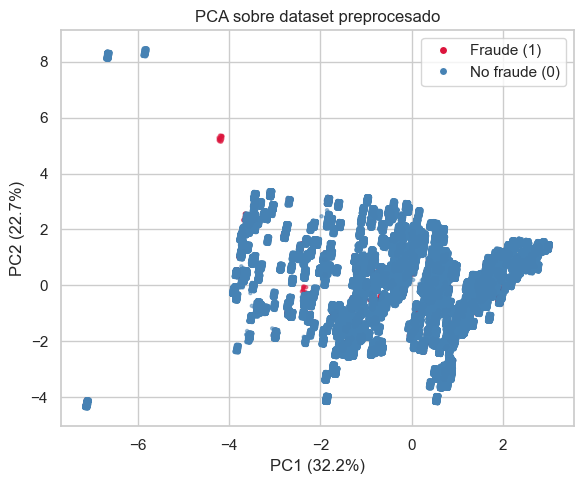

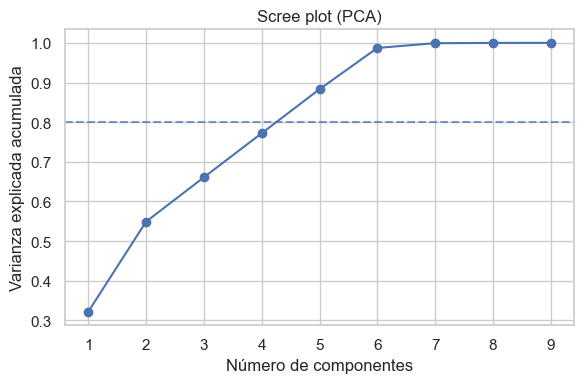


Top 10 |loadings| PC1:
                  PC1       PC2
long        0.576653 -0.096042
merch_long  0.576494 -0.096005
zip        -0.564933 -0.000129
merch_lat   0.069548  0.685985
lat         0.069511  0.686117
city_pop   -0.064748 -0.189837
cc_num     -0.045943 -0.064642
amt        -0.001901  0.002867
unix_time  -0.001241  0.000890

Top 10 |loadings| PC2:
                  PC1       PC2
lat         0.069511  0.686117
merch_lat   0.069548  0.685985
city_pop   -0.064748 -0.189837
long        0.576653 -0.096042
merch_long  0.576494 -0.096005
cc_num     -0.045943 -0.064642
amt        -0.001901  0.002867
unix_time  -0.001241  0.000890
zip        -0.564933 -0.000129


In [76]:
# Limpieza rápida para evitar desalineaciones

mask = ~X.isna().any(axis=1)
X = X.loc[mask]
if y is not None:
    y = y.loc[mask]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
print("Varianza explicada (PC1, PC2):", pca.explained_variance_ratio_,
      "| Acumulada:", pca.explained_variance_ratio_.sum())

# Scatter 2D coloreado por clase (evita warnings de cmap)
plt.figure(figsize=(6,5))
if y is None:
    plt.scatter(Z[:, 0], Z[:, 1], s=5, alpha=0.5)
else:
    colors = np.where(y.values == 1, 'crimson', 'steelblue')
    plt.scatter(Z[:, 0], Z[:, 1], c=colors, s=5, alpha=0.5)
    # Leyenda manual
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], marker='o', color='w', label='Fraude (1)',
                      markerfacecolor='crimson', markersize=6),
               Line2D([0], [0], marker='o', color='w', label='No fraude (0)',
                      markerfacecolor='steelblue', markersize=6)]
    plt.legend(handles=handles, loc='best', frameon=True)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("PCA sobre dataset preprocesado")
plt.tight_layout()
plt.show()

# Scree plot
pca_full = PCA().fit(X_scaled)
cum = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.axhline(0.80, ls='--', alpha=0.7)
plt.xlabel('Número de componentes'); plt.ylabel('Varianza explicada acumulada')
plt.title('Scree plot (PCA)'); plt.tight_layout(); plt.show()

# Loadings PC1/PC2

loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1','PC2'])
print("\nTop 10 |loadings| PC1:\n",
      loadings.reindex(loadings['PC1'].abs().sort_values(ascending=False).head(10).index))
print("\nTop 10 |loadings| PC2:\n",
      loadings.reindex(loadings['PC2'].abs().sort_values(ascending=False).head(10).index))


### PCA: visualización, resumen e interpretación

**Motivación.**  
Dado que la matriz de correlaciones no muestra relaciones lineales fuertes entre predictores (no hay pares con |ρ| ≥ 0.8), aplicamos **PCA** para:  
(i) sintetizar la información en pocas dimensiones y  
(ii) facilitar la visualización de posibles estructuras o clusters en 2D.

---

**Qué se muestra:**  
Cada punto del gráfico PCA representa una transacción proyectada en los dos primeros componentes principales, calculados a partir del dataset preprocesado y estandarizado.  
- **PC1** (32.19% varianza) y **PC2** (22.72% varianza) son combinaciones lineales de las variables originales que maximizan la varianza explicada.  
- Los puntos están coloreados por `is_fraud` (rojo = fraude; azul = no fraude), manteniendo la alineación exacta tras limpieza/imputación.

---

**Lectura del gráfico:**  
- **Varianza explicada:** PC1+PC2 capturan ≈ 54.91% de la varianza total.  
- **Separación de clases:** No hay frontera clara entre fraude y no fraude; los casos de fraude aparecen dispersos entre las transacciones legítimas.  
- **Patrones visibles:** Distribución organizada principalmente por variables geográficas (longitud y latitud), lo que se confirma en las cargas (*loadings*).  
- **Outliers:** Algunos puntos alejados podrían ser transacciones atípicas.

---

**Scree plot:**  
- La curva de varianza **acumulada** indica que se necesitan **≈5 componentes** para superar el umbral del **80%** de varianza explicada

---

**Cargas (loadings) e interpretación:**  
Los loadings indican la contribución de cada variable a cada componente.  
Las 9 variables con mayor peso en PC1 y PC2 son:

| Variable      | PC1     | PC2     | Lectura |
|---------------|---------|---------|---------|
| long          | +0.577  | -0.096  | **PC1** crece con longitudes mayores (ubicaciones más al este) |
| merch_long    | +0.577  | -0.096  | Similar a `long` pero para el comercio |
| zip | -0.565 | -0.000 | Inverso a PC1 *1 |
| merch_lat     | +0.070  | +0.686  | **PC2** crece con latitudes mayores (ubicaciones más al norte) |
| lat           | +0.070  | +0.686  | Similar a `merch_lat` pero para la transacción |
| city_pop      | -0.065  | -0.190  | Pequeña contribución inversa en ambos ejes |
| cc_num        | -0.046  | -0.065  | Baja influencia |
| amt           | -0.002  | +0.003  | Influencia despreciable |
| unix_time     | -0.001  | +0.001  | Influencia despreciable |

x1 refleja el patrón geográfico de los ZIP codes en EE.UU. (valores bajos en el este, altos en el oeste)

**Interpretación:**  
- **PC1** → Eje geográfico este-oeste (longitud y código postal).  
- **PC2** → Eje geográfico norte-sur (latitud).  
- El resto de variables aporta muy poco a estos dos primeros componentes.

---

**Conclusión práctica:**  
- El PCA 2D es útil para visualizar estructura general, patrones geográficos y detectar posibles outliers.  
- No es suficiente para separar fraude/no fraude de forma efectiva; para modelado se requerirán modelos supervisados y posiblemente más componentes o técnicas no lineales.  
- Los ejes principales están dominados por ubicación geográfica, lo que sugiere que otras dimensiones del dataset (tiempo, comportamiento transaccional, etc.) quedan fuera de este plano.


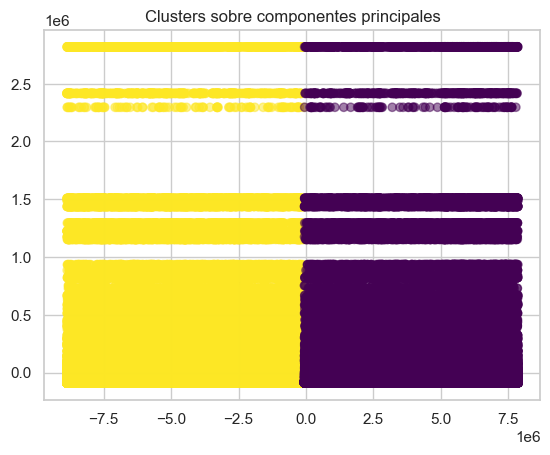

In [78]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X.fillna(0))
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title("Clusters sobre componentes principales")
plt.show()


📌 Conclusión/interpretación

Al aplicar K-Means sobre los dos primeros componentes del PCA, se observan dos grupos bien definidos a lo largo del eje PC1. Dado que PC1 refleja principalmente la ubicación geográfica este-oeste (longitud y código postal), la agrupación detectada por K-Means separa las transacciones según su localización, no según fraude/no fraude. Esto indica que, aunque la técnica de clustering puede identificar patrones geográficos, no es suficiente por sí sola para detectar fraude, ya que la variable de interés no parece concentrarse en un único cluster.

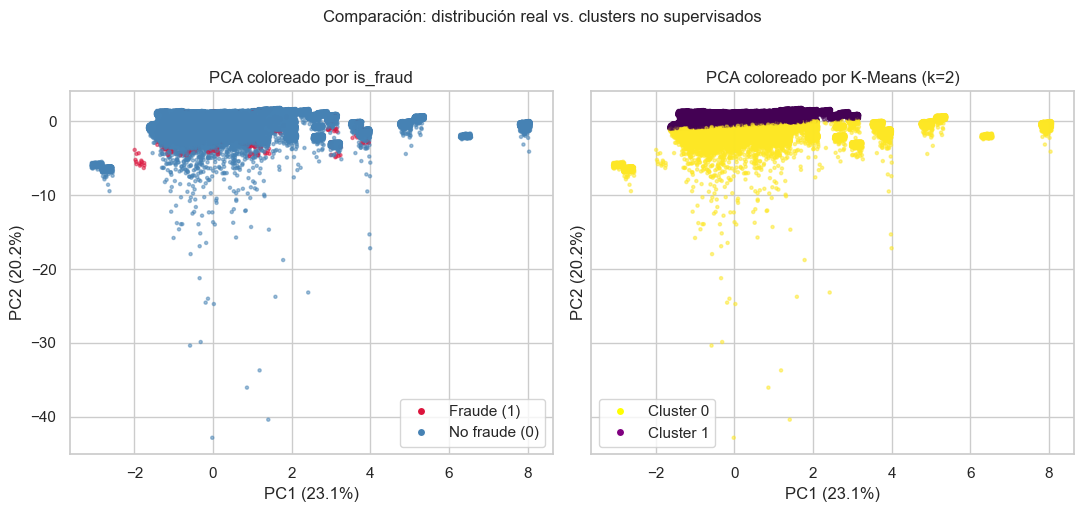

Tasa de fraude por cluster (K-Means):


is_fraud,No fraude,Fraude
row_0,,
0,0.997803,0.002197
1,0.990412,0.009588


In [86]:
# PCA ya calculado → usamos Z, pc1_var, pc2_var, y ya definido

# K-Means en PCA-2D
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
labels = kmeans.fit_predict(Z)

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

# (a) Real: coloreado por fraude
colors_y = np.where(y.values == 1, 'crimson', 'steelblue')
axes[0].scatter(Z[:,0], Z[:,1], c=colors_y, s=5, alpha=0.5)
from matplotlib.lines import Line2D
handles_real = [
    Line2D([0],[0], marker='o', color='w', label='Fraude (1)', markerfacecolor='crimson', markersize=6),
    Line2D([0],[0], marker='o', color='w', label='No fraude (0)', markerfacecolor='steelblue', markersize=6)
]
axes[0].legend(handles=handles_real, loc='best', frameon=True)
axes[0].set_title("PCA coloreado por is_fraud")
axes[0].set_xlabel(f"PC1 ({pc1_var:.1%})")
axes[0].set_ylabel(f"PC2 ({pc2_var:.1%})")

# (b) No supervisado: coloreado por clusters
scatter_kmeans = axes[1].scatter(Z[:,0], Z[:,1], c=labels, cmap='viridis', s=5, alpha=0.5)
handles_kmeans = [
    Line2D([0],[0], marker='o', color='w', label='Cluster 0', markerfacecolor='yellow', markersize=6),
    Line2D([0],[0], marker='o', color='w', label='Cluster 1', markerfacecolor='purple', markersize=6)
]
axes[1].legend(handles=handles_kmeans, loc='best', frameon=True)
axes[1].set_title("PCA coloreado por K-Means (k=2)")
axes[1].set_xlabel(f"PC1 ({pc1_var:.1%})")
axes[1].set_ylabel(f"PC2 ({pc2_var:.1%})")

plt.suptitle("Comparación: distribución real vs. clusters no supervisados", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# Tasa de fraude por cluster
ct = pd.crosstab(labels, y, normalize='index').rename(columns={0:'No fraude',1:'Fraude'})
print("Tasa de fraude por cluster (K-Means):")
display(ct)


### Comparación PCA 2D: Real vs. Clustering no supervisado

- **Gráfico izquierda**: PCA coloreado por la variable real `is_fraud` (rojo = fraude, azul = no fraude).  
  - No se observa separación lineal clara; fraudes y no fraudes se mezclan en el plano PC1–PC2.  

- **Gráfico derecha**: PCA coloreado por **clusters** obtenidos con K-Means (*k*=2, no supervisado).  
  - Los colores representan grupos formados solo en base a similitud geométrica en el espacio PCA.  
  - Los clusters no coinciden directamente con las clases reales, lo que confirma que **la estructura de fraude no es capturable únicamente con PCA lineal y clustering simple**.

📌 *Conclusión*: El PCA-2D es útil para visualización y detección de patrones globales, pero la detección de fraude requiere modelos supervisados y más dimensiones para capturar la complejidad de la señal.


🔢 Test de Benford

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=60217.1


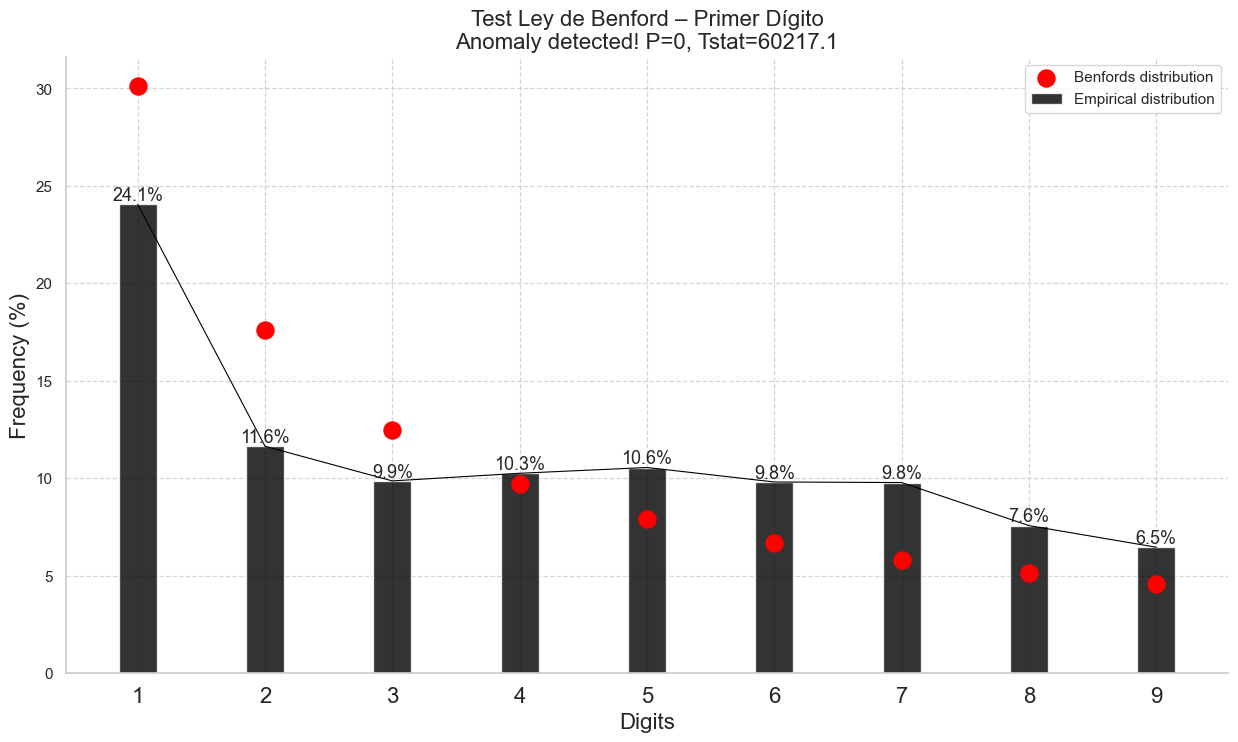

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Test Ley de Benford – Primer Dígito\nAnomaly detected! P=0, Tstat=60217.1'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [79]:
bl = benfordslaw(alpha=0.05)
bl.fit(df['amt'])
bl.plot(title='Test Ley de Benford – Primer Dígito')


🛠️ 4. Ingeniería de Features
Imputación

Codificación

Transformaciones

In [80]:
# Ejemplo de imputación y codificación
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
  transformers=[
    ('num', SimpleImputer(strategy='median'), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
  ])


⚖️ 5. Modelado: Random Forest + Validación Cruzada

In [81]:
# Separar variables
X = df.drop(columns='is_fraud')
y = df['is_fraud']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Definir features
num_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'is_fraud']
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearch
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2]
}

cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


🧮 6. Optimización de Umbral de Corte
(Esto lo implementás en Excel o podemos programarlo en Python)

In [82]:
# Proba predicha
y_proba = grid_search.predict_proba(X_test)[:,1]
threshold = 0.15  # ajustar manualmente o con Solver

y_pred_thresh = (y_proba > threshold).astype(int)

# Matriz de confusión y costos
confusion_matrix(y_test, y_pred_thresh)


array([[138304,     90],
       [   229,    307]])

📈 7. Lift & Gain Charts

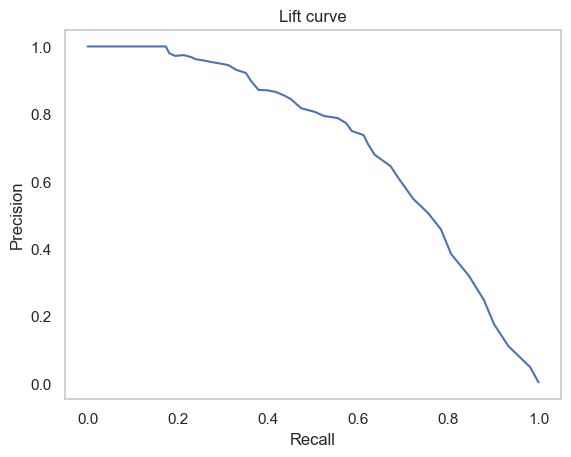

In [83]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lift curve")
plt.grid()
plt.show()


📤 8. Exportación de Resultados y Conclusiones

In [84]:
results = pd.DataFrame({'true': y_test, 'proba': y_proba, 'pred': y_pred_thresh})
results.to_csv("predicciones_rf.csv", index=False)
